In [51]:
from PIL import Image
from transformers import pipeline
import numpy as np
from pathlib import Path

import cv2

In [52]:
import cv2
import torch
import numpy as np
import matplotlib

import time
from picamera2 import Picamera2
from libcamera import Transform
import matplotlib.pyplot as plt

# import from folder Depth-Anything-V2/depth_anything_v2/
from depth_anything_v2.dpt import DepthAnythingV2


Starting depth estimation. This will take about 20-30 seconds
Inference time: 24.294843673706055 seconds
bottle
Average depth of the object: 0.6305105526646776


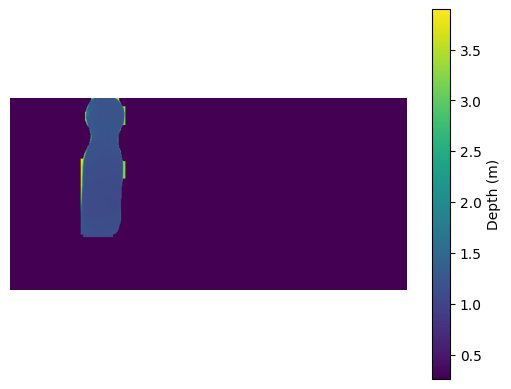

bottle
Average depth of the object: 0.4223546998517696


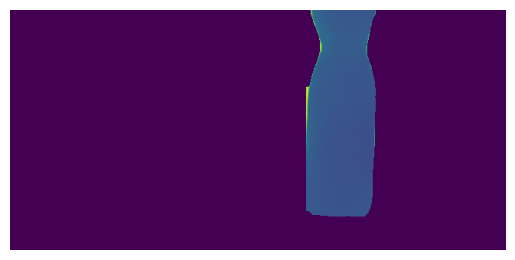

In [66]:

model = None
def init():
    global model
# small, base, 
    model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]}
    }

    encoder = 'vits' # or 'vits', 'vitb'
    dataset = 'hypersim' # 'hypersim' for indoor model, 'vkitti' for outdoor model
    max_depth = 20 # 20 for indoor model, 80 for outdoor model

    #! removed max depth
    model = DepthAnythingV2(**{**model_configs[encoder], 'max_depth': max_depth})
    # download models from: 
    model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_metric_{dataset}_{encoder}.pth', map_location='cpu'))
    model.eval()




def calculateDepth(picam_array):
    global original_depth
    raw_img = picam_array

    start_time = time.time()
    original_depth = model.infer_image(raw_img) # HxW depth map in meters in numpy
    end_time = time.time()

    print(f"Inference time: {end_time - start_time} seconds")

    depth = original_depth.copy()
    depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0
    depth = depth.astype(np.uint8)
    cmap = matplotlib.colormaps.get_cmap('Spectral')

    depth = (cmap(depth)[:, :, :3] * 255)[:, :, ::-1].astype(np.uint8)

    cv2.imwrite('depth_map.png', depth)


    model_base = original_depth.copy()

    calibrated_depth = calibrationData(original_depth.copy())

    plt.imshow(original_depth)
    plt.colorbar(label='Depth (m)')

    return np.array(model_base)



def calibrationData(model_base):
    def applyCorrection(meter): 
        meter = meter + 0.135
        # around 0.1, 0.2
        return meter
    
    # this correction should be applied to the entire depth map
    model_base = np.vectorize(applyCorrection)(model_base)
    return model_base


init()
estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)

# test: adding 13.5cm to entire image, vs just adding 13.5cm at the end


Starting depth estimation. This will take about 20-30 seconds
Inference time: 24.670740604400635 seconds
bottle
Average depth of the object: 0.6305105526646776


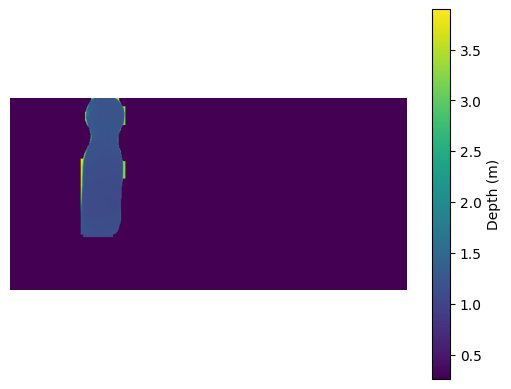

bottle
Average depth of the object: 0.4223546998517696


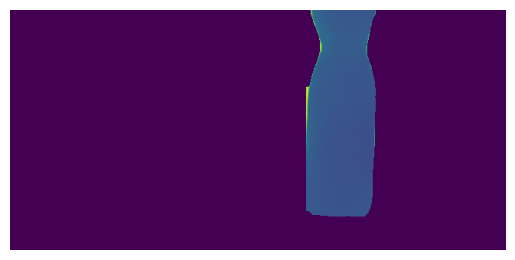

In [61]:
from PIL import Image
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt

pipe = None

# for debug purposes
depthImage = None 

def estimate(picam_array, bottleBox, masks, res):
    global depthImage
    
    print("Starting depth estimation. This will take about 20-30 seconds")
    depthImage = calculateDepth(picam_array)
    # Iterate detection results 
    for r in res:
        img = np.copy(r.orig_img)
        img_name = Path(r.path).stem

        # Iterate each object contour 
        for ci, c in enumerate(r):
            label = c.names[c.boxes.cls.tolist().pop()]
            print(label)

            # just a full black mask
            b_mask = np.zeros(img.shape[:2], np.uint8)

            # Create contour mask 
            contour = c.masks.xy.pop().astype(np.int32).reshape(-1, 1, 2)
            _ = cv2.drawContours(b_mask, [contour], -1, (255, 255, 255), cv2.FILLED)

            # Choose one:

            # OPTION-1: Isolate object with black background
            # mask3ch = cv2.cvtColor(b_mask, cv2.COLOR_GRAY2BGR)
            # isolated = cv2.bitwise_and(mask3ch, img)


            # Convert depthImage to 3-channel image
            # depthImage_3ch = cv2.cvtColor(depthImage, cv2.COLOR_GRAY2BGR)
            
            isolated = cv2.bitwise_and(depthImage, depthImage, mask=b_mask)
            

            # Calculate the average depth value for the masked object
            masked_depth = cv2.bitwise_and(depthImage, depthImage, mask=b_mask)
            average_depth = cv2.mean(masked_depth, mask=b_mask)[0]
            print(f"Average depth of the object: {average_depth}")


            # Display the isolated object using matplotlib
            plt.imshow(isolated)
            plt.axis('off')
            plt.show()




In [55]:
import cv2
from picamera2 import Picamera2

from ultralytics import YOLO
from libcamera import Transform
import time

# from depthest import init, estimate

init


[166:47:34.897040235] [879694]  INFO Camera camera_manager.cpp:325 libcamera v0.3.2+99-1230f78d
[166:47:34.935746882] [891725]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[166:47:34.938297722] [891725]  INFO RPI vc4.cpp:447 Registered camera /base/soc/i2c0mux/i2c@1/imx708@1a to Unicam device /dev/media1 and ISP device /dev/media0
[166:47:34.938370406] [891725]  INFO RPI pipeline_base.cpp:1120 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[166:47:34.968046005] [879694]  INFO Camera camera.cpp:1197 configuring streams: (0) 640x310-RGB888 (1) 1536x864-SGRBG10_CSI2P
[166:47:34.968544373] [891725]  INFO RPI vc4.cpp:622 Sensor: /base/soc/i2c0mux/i2c@1/imx708@1a - Selected sensor format: 1536x864-SGRBG10_1X10 - Selected unicam format: 1536x864-pgAA



0: 224x224 water_bottle 0.45, pop_bottle 0.11, vase 0.11, nipple 0.05, saltshaker 0.03, 112.9ms
Speed: 24.9ms preprocess, 112.9ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)
0
Bottle found with class index 898

0: 320x640 2 bottles, 835.8ms
Speed: 6.5ms preprocess, 835.8ms inference, 9.6ms postprocess per image at shape (1, 3, 320, 640)
More than one bottle detected. Computing all.
Starting depth estimation. This will take about 20-30 seconds
Inference time: 25.634645462036133 seconds
bottle
Average depth of the object: 0.6305105526646776


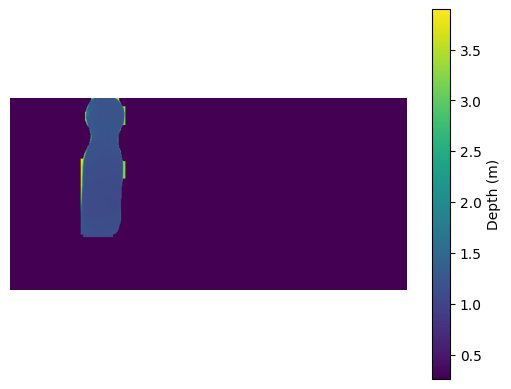

bottle
Average depth of the object: 0.4223546998517696


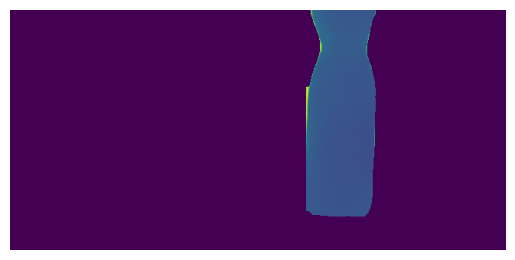

In [60]:
def runModel():
    bottleFrameDetected, bottleBox, bottleMask, segmentResults = None, None, None, None

    print("init")
    with Picamera2() as picam2:
        global bottleFrameDetected, bottleBox, bottleMask, segmentResults
        # Initialize the Picamera2
        # picam2 = Picamera2()

        # default
        # picam2.preview_configuration.main.size = (1280, 720)
        picam2.preview_configuration.main.size = (640, 310)
        # picam2.preview_configuration.main.size = (640 /2, 310/2)

        picam2.preview_configuration.main.format = "RGB888"
        picam2.preview_configuration.align()
        picam2.preview_configuration.transform=Transform(vflip=1)
        picam2.configure("preview")
        picam2.start()


        # Load the YOLO11 model
        # have to run create model first 
        segmentModel = YOLO("yolo11n-seg.pt")  
        model = YOLO("yolo11n-cls.pt")

        instantBreak = False


        # used to record the time when we processed last frame 
        prev_frame_time = 0
        
        # used to record the time at which we processed current frame 
        new_frame_time = 0
        # font which we will be using to display FPS 
        font = cv2.FONT_HERSHEY_SIMPLEX 

        bottleFrameDetected = None
        bottleFrameNew = None

        results = None
        bottleBox = None

        while True:
            # time when we finish processing for this frame 
            # ! do all processing below this, and above the fps calculator
            new_frame_time = time.time() 

            # Capture frame-by-frame
            frame = picam2.capture_array()

            # Run YOLO11 inference on the frame
            results = model(frame)

            # print(results)
            # Visualize the results on the frame
            # annotated_frame = results[0].plot()

            new_frame_time = time.time() 
        
            # Calculating the fps 
            fps = 1/(new_frame_time-prev_frame_time) 
            prev_frame_time = new_frame_time 
            fps = int(fps) 
            fps = str(fps) 
            # cv2.putText(annotated_frame, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA) 
            print(fps)
            # Check if a bottle has been recognized
            for result in results:
                # probs = result.probs  # Probs object for classification outputs
                # print(probs)
                # classification model
                if result.probs != None:
                    # print("Top 5 classes", result.probs.top5)
                    # https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
                    # 440: beer_bottle
                    # 898: water bottle
                    if 898 in result.probs.top5:
                        print("Bottle found with class index 898")
                        bottleFrameDetected = frame
                        instantBreak = True
                        break;


                # for detection in result.boxes:
                # #     # Assuming detection.cls is an integer index for the class
                #     bottleBox = detection
                #     if detection.cls == 39:  # correct class index for "bottle"
                #         print("Bottle recognized", )
                #         print("Probabilty", detection.conf)
                #         bottleFrameDetected = frame
                #         instantBreak = True
                #         break


            # Display the resulting frame
            # cv2.imshow("Camera", annotated_frame)

            if instantBreak:
                break
            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) == ord("q"):
                print("")
                break

        # Release resources and close windows
        cv2.destroyAllWindows()

        # https://docs.ultralytics.com/modes/predict/#__tabbed_1_1
        if bottleFrameDetected is not None:
            # Capture a new frame of the bottle
            # should not be blurry
            bottleFrameNew = picam2.capture_array()
            cv2.imwrite("output/bottle_new.png", bottleFrameNew)

        # Process results list
        # results for bottleFrameDetected
        for result in results:
            boxes = result.boxes  # Boxes object for bounding box outputs
            masks = result.masks  # Masks object for segmentation masks outputs
            keypoints = result.keypoints  # Keypoints object for pose outputs
            probs = result.probs  # Probs object for classification outputs
            obb = result.obb  # Oriented boxes object for OBB outputs
            # result.show()  # display to screen
            result.save(filename="output/bottle_detected.png")  # save to disk

        # segmnet
        segmentResults = segmentModel.predict(source=bottleFrameDetected, classes=39)
        bottleMask = None
        # Process results list
        for result in segmentResults:
            result.save(filename="output/segmented.jpg")  # save to disk

            if (result.masks.shape[0] > 1) :
                print("More than one bottle detected. Computing all.")


            bottleMask = result.masks[0]  # Masks object for segmentation masks outputs

        init()
        estimate(bottleFrameDetected, bottleBox, bottleMask, segmentResults)




    # Stop the camera to free up resources
    picam2.stop() 
    picam2.stop_encoder()

    del picam2


In [ ]:
# run entireModel 4 times
runModel()
runModel()
runModel()
runModel()
